# DengAI Analysis Part 07 - Eliminating Seasonality

By: Chengyi (Jeff) Chen, under guidance of CSCI499: AI for Social Good Teaching Assistant - Aaron Ferber

---
## Content

In this notebook, we will use the seasonality feature created in the last notebook to de-seasonalize our total dengue cases so that our features are purely used to predict the residuals and not the seasonal trend.

<a id="imports"></a>

---
## Library Imports

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import subprocess
import statsmodels.formula.api as sm
from statsmodels import stats as sms
import statsmodels as statsmodels
from scipy import stats
import os
from collections import Counter
from sklearn import model_selection, kernel_ridge, linear_model, metrics, feature_selection, preprocessing
from os import listdir
from os.path import isfile, join, isdir
import warnings
warnings.filterwarnings('ignore')

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
%matplotlib inline

In [2]:
# DengAI dataset URLs
dengai_features_url = 'https://www.dropbox.com/s/1kuf94b4mk6axyy/dengue_features_train.csv'
dengai_labels_url = 'https://www.dropbox.com/s/626ak8397abonv4/dengue_labels_train.csv'
dengai_test_features_url = 'https://s3.amazonaws.com:443/drivendata/data/44/public/dengue_features_test.csv'

In [3]:
# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

<a id="clean_feats"></a>

---
## Cleaned Features & Seasonality  Feature

In [57]:
# Training Features and Labels
sj_X_train = pd.read_csv('./data/dengai/cleaned/sj_X.csv', index_col='week_start_date')
sj_y_train = pd.read_csv('./data/dengai/cleaned/sj_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')
iq_X_train = pd.read_csv('./data/dengai/cleaned/iq_X.csv', index_col='week_start_date')
iq_y_train = pd.read_csv('./data/dengai/cleaned/iq_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')

In [5]:
test_feats_df = pd.read_csv('./data/dengai/test_features/dengue_features_test.csv', index_col='week_start_date')

# Taking care of missing data
test_feats_df.fillna(test_feats_df.mode().iloc[0], inplace=True)

# Drop unecessary feature columns
test_feats_df = test_feats_df.drop(['year', 'weekofyear'], axis=1)

# Split dataset to City sj and City iq
sj_X_test = test_feats_df[test_feats_df['city'] == 'sj'].drop(['city'], axis=1)
iq_X_test = test_feats_df[test_feats_df['city'] == 'iq'].drop(['city'], axis=1)

In [6]:
# Seasonality Feature from SARIMA
sj_seasonality = pd.read_csv('./data/dengai/cleaned/sj_seasonality.csv', index_col=[0]).rename({'num_cases': 'seasonality'}, axis='columns')
iq_seasonality = pd.read_csv('./data/dengai/cleaned/iq_seasonality.csv', index_col=[0]).rename({'num_cases': 'seasonality'}, axis='columns')

In [7]:
# Truncate Training and Test set so as to include seasonality
sj_X_train = pd.concat([sj_X_train.loc[sj_seasonality.first_valid_index():], sj_seasonality.loc[sj_seasonality.first_valid_index():sj_X_train.last_valid_index()]], axis=1)
sj_y_train = sj_y_train.loc[sj_seasonality.first_valid_index():]
iq_X_train = pd.concat([iq_X_train.loc[iq_seasonality.first_valid_index():], iq_seasonality.loc[iq_seasonality.first_valid_index():iq_X_train.last_valid_index()]], axis=1)
iq_y_train = iq_y_train.loc[iq_seasonality.first_valid_index():]

sj_X_test = pd.concat([sj_X_test, sj_seasonality.loc[sj_X_test.first_valid_index():]], axis=1)
iq_X_test = pd.concat([iq_X_test, iq_seasonality.loc[iq_X_test.first_valid_index():]], axis=1)

---
## Problem of Covariate Shifting (Accounting for Seasonality in Features)

In addition to adding the new seasonality feature we created with SARIMA in the previous notebook, I also wanted to further examine whether the features which we were training on come from the same distribution as our testing features. There is a possibility of this [covariate shift problem](http://blog.smola.org/post/4110255196/real-simple-covariate-shift-correction) because in the previous parts, our MAE scores on the training features seemed to be doing quite well, but when we submitted them, the model got a horrible MAE. Submitting the Seasonality feature alone as the predicted number of cases got an EVEN BETTER MAE score than using a machine learning model, so let's check to see if the distributions are different and explore what we could do to correct this. Furthermore, even though we've accounted for the seasonality in the total number of dengue cases using the new seasonality feature from SARIMA previously, there might still be other seasonal differences hidden in our feature space that we also need to  account  for, such as "higher-order" seasonalities in our features and seasonalities on our seasonalities. Remember, many of the machine learning models we use assume that the data points are [__independent, and identically distributed__](https://stats.stackexchange.com/questions/213464/on-the-importance-of-the-i-i-d-assumption-in-statistical-learning), making this process of de-seasonalizing very important for them to perform well.

### Correlations of Exogenous with Endogenous

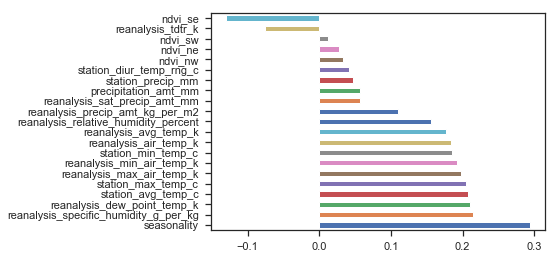

In [8]:
# City SJ
(pd.concat([sj_X_train, sj_y_train], axis=1)
 .corr()
 .num_cases
 .drop('num_cases') # Don't compare with itself
 .sort_values(ascending=False)
 .plot
 .barh());

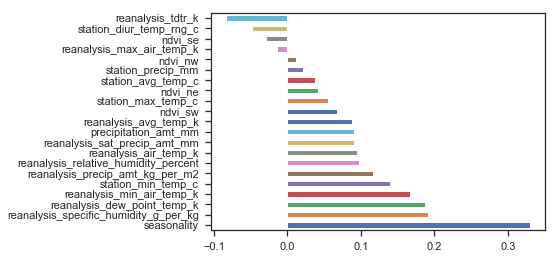

In [9]:
# City IQ
(pd.concat([iq_X_train, iq_y_train], axis=1)
 .corr()
 .num_cases
 .drop('num_cases') # Don't compare with itself
 .sort_values(ascending=False)
 .plot
 .barh());

Looking at the correlations, it does seem like we have to pay special attention at the temperature and humidity features

### Check if the Competition Training Features and Test Features come from the Same Distribution
We will use the 2 sample Kolmogorov-Smirnov test statistic to determine whether the training features and testing features come from the same distribution

In [10]:
def KS_test(X_train, X_test, alpha=0.05):
    """
    ============
    = FUNCTION =
    ============
    Performs KS test on Train and Test features to see if they are drawn from different distributions
    
    ==============
    = PARAMETERS =
    ==============
    X_train: The Training features
    X_test:  The Testing features
    alpha: Significance level to reject the null that X_train and X_test are drawn from same distribution
    
    ===========
    = RETURNS =
    ===========
    Pandas DataFrame of KS test results for each feature
    """
    ks = {feat: {'ks_stat': None, 'p-value': None} for feat in X_train.drop(['seasonality'], axis=1).columns}

    # Check if the distribution of features 
    # for the Training and Testing set is  
    # significantly different
    for feat in X_train.drop(['seasonality'], axis=1).columns:

        ks_stat, p_val = stats.ks_2samp(X_train[feat].values, X_test[feat].values)

        if p_val < alpha:
            print('Training and Testing distributions of {} are significantly different with {}% confidence'.format(feat, (1-alpha)*100))
        
        ks[feat]['ks_stat'] = ks_stat
        ks[feat]['p-value'] = p_val
        
    return pd.DataFrame.from_dict(ks).transpose()

In [11]:
# KS Test on City SJ features
KS_test(sj_X_train, sj_X_test, alpha=0.01)

Training and Testing distributions of ndvi_ne are significantly different with 99.0% confidence
Training and Testing distributions of ndvi_nw are significantly different with 99.0% confidence
Training and Testing distributions of ndvi_sw are significantly different with 99.0% confidence
Training and Testing distributions of precipitation_amt_mm are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_air_temp_k are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_avg_temp_k are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_dew_point_temp_k are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_min_air_temp_k are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_precip_amt_kg_per_m2 are significantly different with 99.0% confidence
Training and Testing distribution

,ks_stat,p-value
ndvi_ne,0.345924,1.293898e-21
ndvi_nw,0.204535,7.821258e-08
ndvi_se,0.068886,2.880394e-01
ndvi_sw,0.132836,1.501490e-03
precipitation_amt_mm,0.120666,5.282118e-03
reanalysis_air_temp_k,0.184673,1.828697e-06
reanalysis_avg_temp_k,0.171297,1.274175e-05
reanalysis_dew_point_temp_k,0.115442,8.733921e-03
reanalysis_max_air_temp_k,0.112801,1.116690e-02
reanalysis_min_air_temp_k,0.151780,1.666495e-04


In [12]:
# KS Test on City IQ features
KS_test(iq_X_train, iq_X_test, alpha=0.01)

Training and Testing distributions of ndvi_nw are significantly different with 99.0% confidence
Training and Testing distributions of precipitation_amt_mm are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_precip_amt_kg_per_m2 are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_sat_precip_amt_mm are significantly different with 99.0% confidence
Training and Testing distributions of station_precip_mm are significantly different with 99.0% confidence


,ks_stat,p-value
ndvi_ne,0.081620,4.326702e-01
ndvi_nw,0.221904,2.631674e-05
ndvi_se,0.134203,3.279584e-02
ndvi_sw,0.103141,1.763144e-01
precipitation_amt_mm,0.155099,8.253519e-03
reanalysis_air_temp_k,0.086761,3.567729e-01
reanalysis_avg_temp_k,0.093072,2.762176e-01
reanalysis_dew_point_temp_k,0.074830,5.451579e-01
reanalysis_max_air_temp_k,0.067398,6.777616e-01
reanalysis_min_air_temp_k,0.126623,5.149759e-02


It does seem that we might have found the root problem of why our models are so bad at predicting for the test features - our training features are mostly significantly different from our competition testing features. However, we need to check whether this significant difference might be purely due to seasonality or if there's something else that's causing them to be different. As a proxy, let's check if the features at different timesteps in our training data are significantly different.

In [13]:
# Seeing if there is a large difference between one 
# half of our training features and the other half of
# our  training features
KS_test(sj_X_train.iloc[:len(sj_X_train)//2], sj_X_train.iloc[len(sj_X_train)//2:len(sj_X_train)], alpha=0.01)

Training and Testing distributions of ndvi_ne are significantly different with 99.0% confidence
Training and Testing distributions of ndvi_nw are significantly different with 99.0% confidence
Training and Testing distributions of ndvi_se are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_air_temp_k are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_avg_temp_k are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_max_air_temp_k are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_min_air_temp_k are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_precip_amt_kg_per_m2 are significantly different with 99.0% confidence
Training and Testing distributions of reanalysis_relative_humidity_percent are significantly different with 99.0% confidence
Training and Testin

,ks_stat,p-value
ndvi_ne,0.251924,1.227849e-12
ndvi_nw,0.307028,1.454227e-18
ndvi_se,0.143931,2.064877e-04
ndvi_sw,0.058753,4.289416e-01
precipitation_amt_mm,0.029310,9.912086e-01
reanalysis_air_temp_k,0.238353,2.341310e-11
reanalysis_avg_temp_k,0.222187,6.338625e-10
reanalysis_dew_point_temp_k,0.070700,2.181060e-01
reanalysis_max_air_temp_k,0.187752,3.297729e-07
reanalysis_min_air_temp_k,0.153406,5.926713e-05


It does seem like temperature and humidity which are highly correlated with the total number of dengue cases are very different for both halves of the dataset, meaning that there are probably temporal dependencies that we have to account for.

In [14]:
# Seeing if there is a large difference between one 
# half of our training features and the other half of
# our  training features
KS_test(sj_X_train.iloc[:52], sj_X_train.iloc[52:52*2], alpha=0.01)

Training and Testing distributions of station_diur_temp_rng_c are significantly different with 99.0% confidence


,ks_stat,p-value
ndvi_ne,0.153846,0.534016
ndvi_nw,0.134615,0.702120
ndvi_se,0.173077,0.383104
ndvi_sw,0.211538,0.171117
precipitation_amt_mm,0.192308,0.261726
reanalysis_air_temp_k,0.134615,0.702120
reanalysis_avg_temp_k,0.153846,0.534016
reanalysis_dew_point_temp_k,0.153846,0.534016
reanalysis_max_air_temp_k,0.153846,0.534016
reanalysis_min_air_temp_k,0.134615,0.702120


Specifically, now checking the distribution of features between a period of 1 year reveals that there is definitely a seasonal pattern of a year in our features.

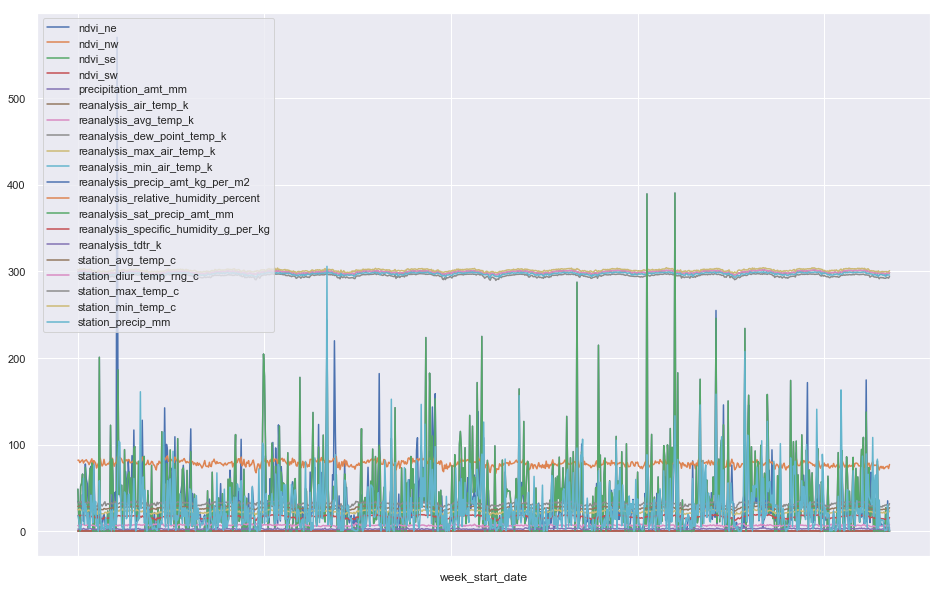

In [15]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(16,10), sharex=True)
sj_X_train.drop(['seasonality'], axis=1).plot(ax=ax);

---
## Feature Extraction

For now, we'll just assume that there exists a single seasonal pattern in the feature space, where the same pattern occurs every 52 weeks, so let's just find the mean of each feature in every 52-week period and subtract it from each 52-week point, this will make more sense later.

In [16]:
def deseasonalize(X, period=52):
    """
    ============
    = FUNCTION =
    ============
    Removes the seasonality from each feature and returns the seasonality of each feature in a new dataframe
    
    ==============
    = PARAMETERS =
    ==============
    X: The features
    period: The period in which seasonality is found
    
    ===========
    = RETURNS =
    ===========
    Returns deseasonalized features and seasonality component in a new dataframe
    """
    
    deseasonalized_feats = pd.DataFrame(index=X.index)
    seasonality = pd.DataFrame(index=X.index)
    
    # Number of seasons inside our dataset
    num_full_seasons = X.shape[0] // period
    leftover = X.shape[0] % period
    
    # Getting the mean of each feature in each season period
    for feat in X.columns:
        
        # A single pattern in the period
        pattern = []
        
        # Getting mean for each 52-week period
        for idx in range(period):
            pattern.append(np.mean([X.iloc[row_idx][feat] for row_idx in range(idx, X.shape[0], period)]))
            
        # Creating seasonality component
        feat_season = []
        for idx in range(num_full_seasons):
            feat_season += pattern
            
        feat_season += pattern[:leftover]
        
        # Adding Seasonality component to dataframe
        seasonality = pd.concat([seasonality, 
                                 pd.DataFrame({feat + '_seasonality': feat_season}, index=X.index)], axis=1)
        
        # Subtracting seasonality from original feature
        deseasonalized_feats = pd.concat([deseasonalized_feats, 
                                          pd.DataFrame({feat + '_deseasonalized': np.subtract(X[[feat]].values, seasonality[[feat + '_seasonality']].values).flatten()}, index=X.index)], axis=1)
        
        
    return seasonality, deseasonalized_feats

In [17]:
sj_seasonality_feats, sj_deseasonalize_feats = deseasonalize(pd.concat([sj_X_train, sj_X_test], axis=0))

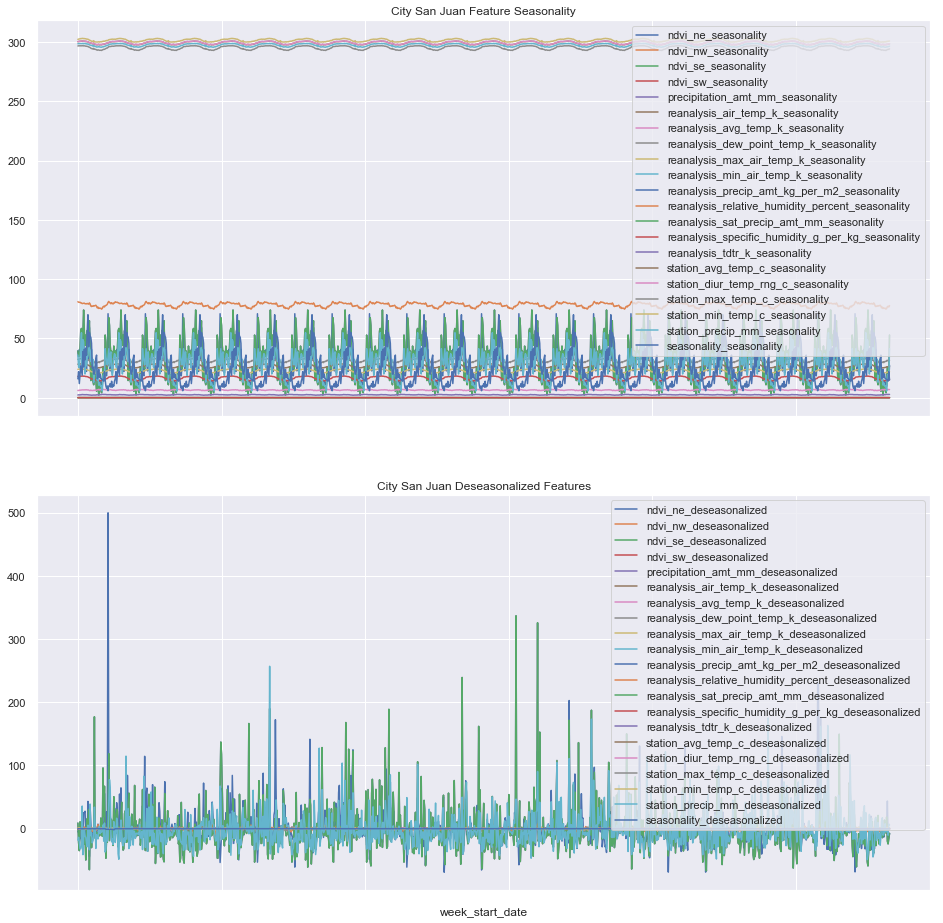

In [18]:
sns.set()
fig, ax = plt.subplots(2, 1, figsize=(16,16), sharex=True)
ax[0].set_title('City San Juan Feature Seasonality')
sj_seasonality_feats.plot(ax=ax[0])
ax[1].set_title('City San Juan Deseasonalized Features')
sj_deseasonalize_feats.plot(ax=ax[1]);

In [19]:
iq_seasonality_feats, iq_deseasonalize_feats = deseasonalize(pd.concat([iq_X_train, iq_X_test], axis=0))

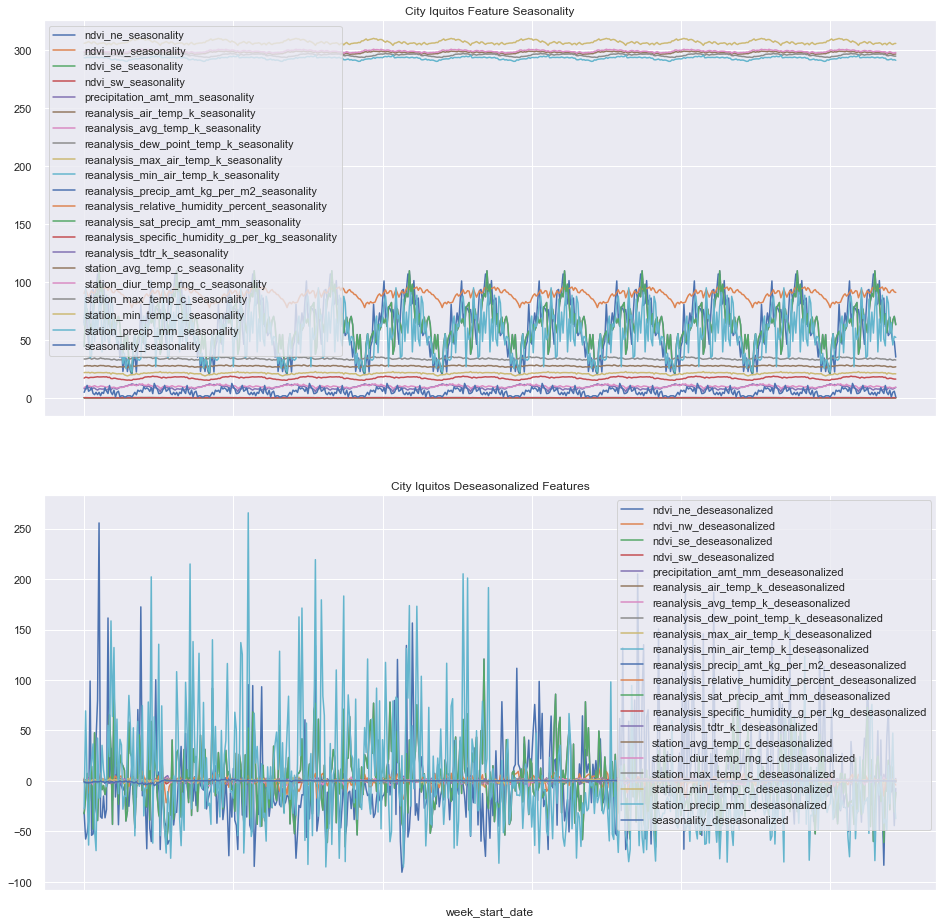

In [20]:
sns.set()
fig, ax = plt.subplots(2, 1, figsize=(16,16), sharex=True)
ax[0].set_title('City Iquitos Feature Seasonality')
iq_seasonality_feats.plot(ax=ax[0])
ax[1].set_title('City Iquitos Deseasonalized Features')
iq_deseasonalize_feats.plot(ax=ax[1]);

---
## Deseasonalized Features and Labels

In [21]:
sj_X_train = sj_deseasonalize_feats.loc[sj_X_train.index]
sj_y_train = pd.DataFrame({'total_cases': np.subtract(sj_y_train.values.flatten(), sj_seasonality.loc[sj_seasonality.first_valid_index():sj_X_train.last_valid_index()].values.flatten())}, index=sj_y_train.index)
iq_X_train = iq_deseasonalize_feats.loc[iq_X_train.index]
iq_y_train = pd.DataFrame({'total_cases': np.subtract(iq_y_train.values.flatten(), iq_seasonality.loc[iq_seasonality.first_valid_index():iq_X_train.last_valid_index()].values.flatten())}, index=iq_y_train.index)

sj_X_test = sj_deseasonalize_feats.loc[sj_X_test.index]
iq_X_test = iq_deseasonalize_feats.loc[iq_X_test.index]

### Standardization

In [22]:
# Import standard scaler module
from sklearn.preprocessing import StandardScaler

# Scale City sj features
sj_X_std_scaler = StandardScaler()
sj_X_train_scaled = sj_X_std_scaler.fit_transform(sj_X_train)

# Scale City iq features
iq_X_std_scaler = StandardScaler()
iq_X_train_scaled = iq_X_std_scaler.fit_transform(iq_X_train)

---

## Training with Transformed Features
__Now let's start training all the previous models we used in Part 2 with the transformed features__

In [23]:
# Import models and utilities from sklearn
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import defaultdict
from time import time

# Let's define a function that'll settle the training
# testing pipeline for us
def train(X, y, mods):
    """
    Handles the entire train and testing pipeline
    
    Parameters:
    -----------
    X: (pandas.DataFrame) Feature columns
    y: (pandas.DataFrame) Labels
    mods: (list) List of sklearn models to be trained on
    
    Returns:
    --------
    DataFrame of results of training and also a dictionary of the trained models
    """
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y).flatten()
    
    # Initialize models dictionary
    trained_mods = {str(mod())[:str(mod()).find('(')]: mod for mod in mods}
    
    # Initialize model performance dictionary
    performance_mods = {str(mod())[:str(mod()).find('(')]: defaultdict(float) for mod in mods}
        
    # Loop through all models
    for idx, (mod_name, mod) in enumerate(trained_mods.items()):
        
        # Trained Model
        trained_mod = mod()
        
        # MAE score
        mae_train = []
        mae_test = []
        
        for test_size in range(10, 60, 5):
        
            # Train Test Splits
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size/100, random_state=42, shuffle=False)

            ################
            ### TRAINING ###
            ################
            # Fit the model
            trained_mod = trained_mod.fit(X_train, y_train) 

            # Prediction scores for training set
            y_train_pred = trained_mod.predict(X_train).astype(int)
            mae_train.append(mean_absolute_error(y_train, y_train_pred))

            ###############
            ### TESTING ###
            ###############
            # Prediction scores for testing set
            y_test_pred = trained_mod.predict(X_test).astype(int)
            mae_test.append(mean_absolute_error(y_test, y_test_pred))
        
        # Saving average train scores
        performance_mods[mod_name]['train_' + str(mean_absolute_error.__name__)] = np.mean(mae_train)
        
        # Saving average test scores
        performance_mods[mod_name]['test_' + str(mean_absolute_error.__name__)] = np.mean(mae_test)
        
        # Saving last trained model
        trained_mods[mod_name] = trained_mod
            
    return performance_mods, trained_mods

In [24]:
# Let's declare the list of models we want to train
mods_to_train = [LinearRegression, BayesianRidge, ElasticNet, GaussianProcessRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, KernelRidge, SVR, MLPRegressor]

In [25]:
# City SJ
sj_performance_mods, sj_trained_mods = train(sj_X_train_scaled, sj_y_train, mods_to_train)
pd.DataFrame.from_dict(sj_performance_mods).transpose()

,test_mean_absolute_error,train_mean_absolute_error
LinearRegression,33.683914,32.787119
BayesianRidge,32.043543,32.005759
ElasticNet,30.376247,31.013492
GaussianProcessRegressor,21.383412,0.877700
RandomForestRegressor,34.513810,11.841555
AdaBoostRegressor,41.198541,30.371852
GradientBoostingRegressor,31.468851,13.754183
KernelRidge,26.194115,32.354546
SVR,20.255342,26.895049
MLPRegressor,28.834891,29.408270


In [31]:
# City IQ
iq_performance_mods, iq_trained_mods = train(iq_X_train_scaled, iq_y_train, mods_to_train)
pd.DataFrame.from_dict(iq_performance_mods).transpose()

,test_mean_absolute_error,train_mean_absolute_error
LinearRegression,7.391553,5.771250
BayesianRidge,7.007555,5.488698
ElasticNet,6.848167,5.435301
GaussianProcessRegressor,6.599916,0.899536
RandomForestRegressor,7.073381,2.557108
AdaBoostRegressor,7.543269,4.726244
GradientBoostingRegressor,6.664787,2.078807
KernelRidge,7.713418,5.791604
SVR,6.677913,5.042665
MLPRegressor,7.380016,4.887611


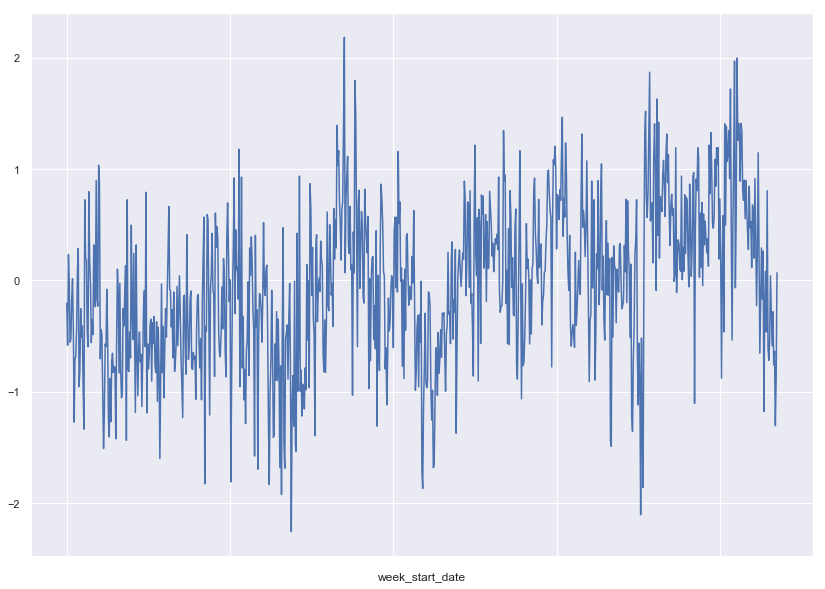

In [27]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(14,10), sharex=True)
sj_X_train['reanalysis_max_air_temp_k_deseasonalized'].plot(ax=ax);

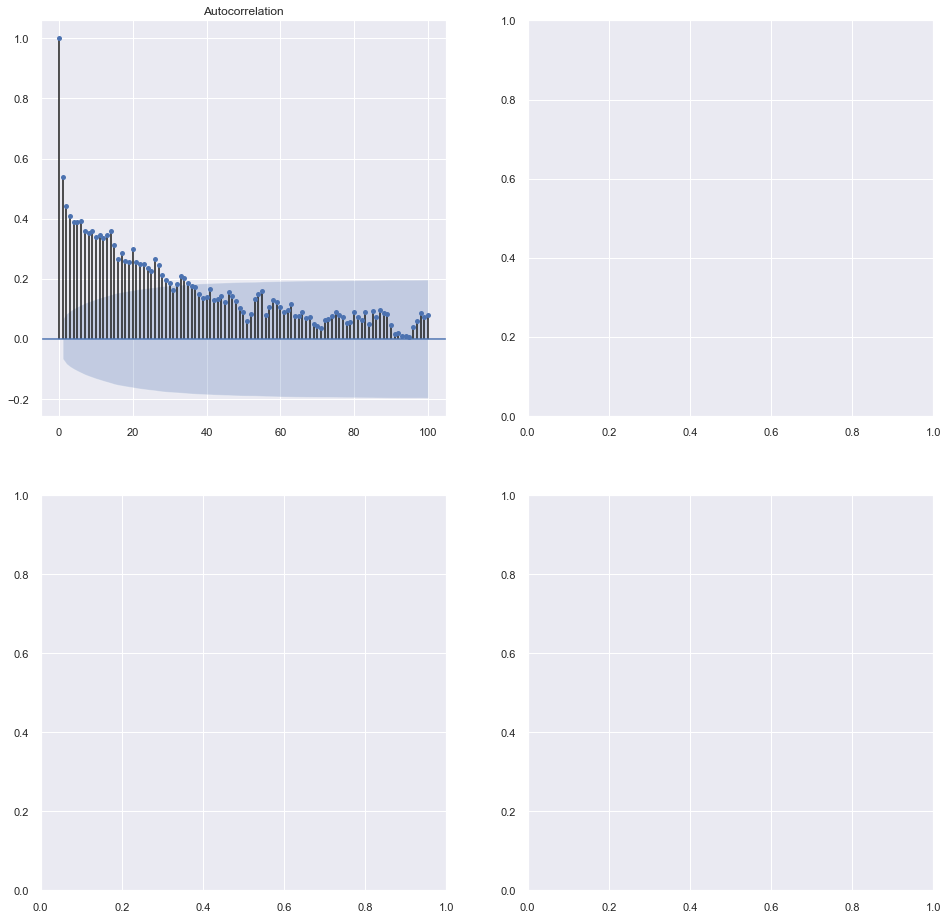

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,2)
rcParams['figure.figsize'] = 16, 16

sj_acf = plot_acf(sj_X_train['reanalysis_max_air_temp_k_deseasonalized'], ax=ax[0,0], lags=100)

In [28]:
# TODO: Seems like we need to do more to eliminate the trend

<a id="test"></a>

---
## Competition Test Prediction

### Prediction

In [32]:
# Save the results to csv and upload to competition
submission_df = pd.read_csv('./data/dengai/submission_format.csv')

# City SJ
sj_submission_df = submission_df[submission_df['city'] == 'sj'].drop(['total_cases'], axis=1)
sj_submission_df.reset_index(inplace=True)
sj_submission_df = pd.concat([sj_submission_df, 
                              pd.DataFrame(np.add(sj_trained_mods['SVR'].predict(sj_X_std_scaler.transform(sj_X_test)), sj_seasonality.loc[sj_X_test.first_valid_index():].values.flatten()).astype(int),
                                           columns=['total_cases'])], 
                             axis=1)
sj_submission_df.index = sj_submission_df['index']
sj_submission_df.drop(['index'], axis=1, inplace=True)

# City IQ
iq_submission_df = submission_df[submission_df['city'] == 'iq'].drop(['total_cases'], axis=1)
iq_submission_df.reset_index(inplace=True)
iq_submission_df = pd.concat([iq_submission_df, 
                              pd.DataFrame(np.add(iq_trained_mods['SVR'].predict(iq_X_std_scaler.transform(iq_X_test)), iq_seasonality.loc[iq_X_test.first_valid_index():].values.flatten()).astype(int), 
                                           columns=['total_cases'])], 
                             axis=1)
iq_submission_df.index = iq_submission_df['index']
iq_submission_df.drop(['index'], axis=1, inplace=True)

submission_df = pd.concat([sj_submission_df, iq_submission_df], axis=0).reset_index().drop(['index'], axis=1)
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,20
1,sj,2008,19,13
2,sj,2008,20,20
3,sj,2008,21,16
4,sj,2008,22,21


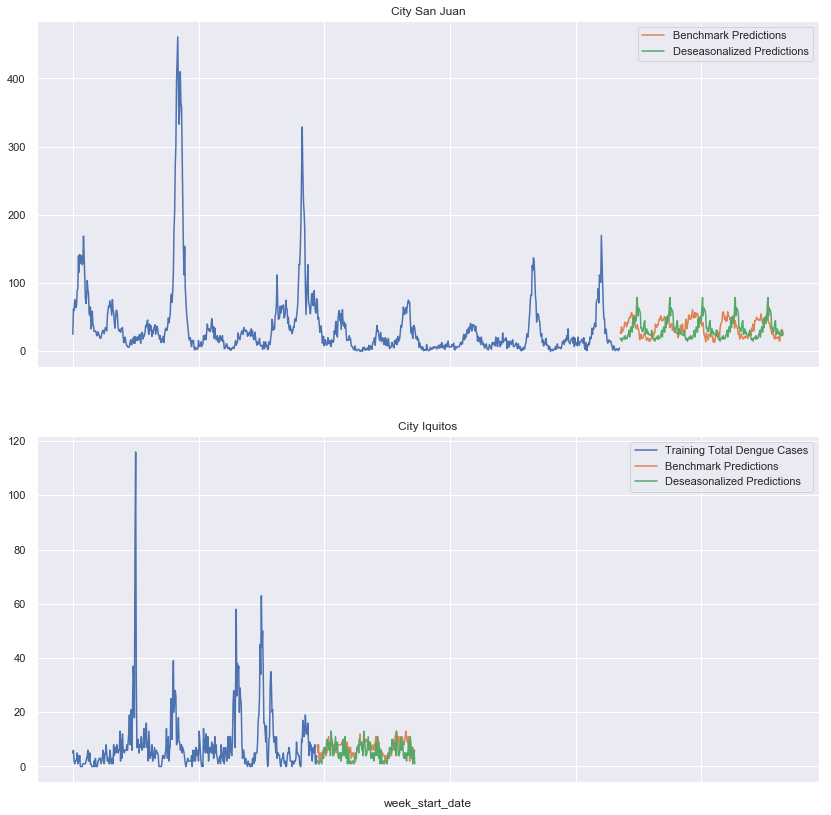

In [37]:
# Benchmark Predictions
benchmark = pd.read_csv('./data/dengai/benchmark.csv')

sj_bench = benchmark[benchmark['city'] == 'sj']['total_cases']
sj_bench = pd.DataFrame(
    [np.nan for i in range(len(sj_X_train))] + list(sj_bench.values),
    index=sj_X_train.index.append(sj_X_test.index), 
    columns=['Benchmark Predictions'])

iq_bench = benchmark[benchmark['city'] == 'iq']['total_cases']
iq_bench = pd.DataFrame(
    [np.nan for i in range(len(iq_X_train))] + list(iq_bench.values),
    index=iq_X_train.index.append(iq_X_test.index),
    columns=['Benchmark Predictions'])

# Deseasonalized Predictions
sj_deseasonalized = sj_trained_mods['SVR'].predict(sj_X_test).astype(int)
sj_deseasonalized = pd.DataFrame([np.nan for i in range(len(sj_X_train))] + # list(sj_deseasonalized),
                                 list(np.add(sj_deseasonalized, sj_seasonality.loc[sj_X_test.first_valid_index():]['seasonality'])),
                         index=sj_X_train.index.append(sj_X_test.index),
                         columns=['Deseasonalized Predictions'])

iq_deseasonalized = iq_trained_mods['SVR'].predict(iq_X_test).astype(int)
iq_deseasonalized = pd.DataFrame([np.nan for i in range(len(iq_X_train))] + # list(iq_deseasonalized),
                                 list(np.add(iq_deseasonalized, iq_seasonality.loc[iq_X_test.first_valid_index():]['seasonality'])),
                         index=iq_X_train.index.append(iq_X_test.index),
                         columns=['Deseasonalized Predictions'])

# Plot 
sns.set()
fig, ax = plt.subplots(2, 1, figsize=(14, 14), sharex=True)

ax[0].set_title("City San Juan")
ax[0].plot(np.add(sj_y_train[['total_cases']].values.flatten(), sj_seasonality.loc[sj_X_train.first_valid_index():sj_X_train.last_valid_index()]['seasonality'].values), label="Training Total Dengue Cases")
sj_bench.plot(ax=ax[0])
sj_deseasonalized.plot(ax=ax[0])

ax[1].set_title("City Iquitos")
ax[1].plot(np.add(iq_y_train[['total_cases']].values.flatten(), iq_seasonality.loc[iq_X_train.first_valid_index():iq_X_train.last_valid_index()]['seasonality'].values), label="Training Total Dengue Cases")
iq_bench.plot(ax=ax[1])
iq_deseasonalized.plot(ax=ax[1])

plt.legend()
plt.show();

In [34]:
# Save to csv
submission_df.to_csv('./data/dengai/deseasonalized_submission.csv', index=False)

This got us our best **MAE** so far, **26.0577**!